Book Recommendation System
We will build a collaborative filtering recommendation system where we will cluster users based on similarities in book likings.
Here we will build a book recommendation engine and compare k-means(Flat) and Agglomerative Clustering(Hierarchical) clustering for the application.



In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image,display
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score ,silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
import gc
gc.collect()

0

In [3]:
books = pd.read_csv('/content/drive/MyDrive/Softronics/Classwork/Books.csv',low_memory=False)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
users = pd.read_csv('/content/drive/MyDrive/Softronics/Classwork/Users.csv',low_memory=False)
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
Ratings = pd.read_csv('/content/drive/MyDrive/Softronics/Classwork/Ratings.csv')
ratings=Ratings.head(400000)

In [6]:
books['Year-Of-Publication'].describe()

count     271360
unique       118
top         2002
freq       17627
Name: Year-Of-Publication, dtype: object

The min values suggest we have some invalid values for the year of publication. Hence we have to trim some values.

In [7]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books = books[(books['Year-Of-Publication']>=1950) & (books['Year-Of-Publication']<=2016)]

In [8]:
users.Age.describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [9]:
users = users[(users.Age>=15) & (users.Age<=100)]

In [10]:
print("shape before cleaning:",ratings.shape)
ratings = ratings[ratings['ISBN'].isin(list(books['ISBN'].unique()))]
ratings = ratings[ratings['User-ID'].isin(list(users['User-ID'].unique()))]
print("shape after cleaning:",ratings.shape)

shape before cleaning: (400000, 3)
shape after cleaning: (243794, 3)


We have to define whether a person likes or dislikes the book for our filtering. Criteria for that will be: If a person rates a book more than their average rating, they like the book. We are doing so because clustering users based on ratings can be problematic as we can’t expect users to maintain scale uniformity.

In [11]:
# Taking the mean of rating given by each user
User_rating_mean = ratings.groupby('User-ID')['Book-Rating'].mean()
user_rating = ratings.set_index('User-ID')
user_rating['mean_rating'] = User_rating_mean
user_rating.reset_index(inplace=True)

In [12]:
# Keeping the books in which users "likes" the book
user_rating = user_rating[user_rating['Book-Rating'] > user_rating['mean_rating']]

In [13]:
# Initializing a dummy variable for future use
user_rating['is_fav'] = 1
print(user_rating.shape)
user_rating.head()

(75960, 5)


<ipython-input-13-abc63f15ef3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating['is_fav'] = 1


,User-ID,ISBN,Book-Rating,mean_rating,is_fav
2,276729,521795028,6,4.5,1
4,276747,60517794,9,5.0,1
7,276747,671537458,9,5.0,1
8,276747,679776818,8,5.0,1
9,276747,943066433,7,5.0,1


In [14]:
#create a crosstab
data = pd.pivot_table(user_rating, index='User-ID', columns='ISBN', values='is_fav', fill_value=0)
# df = pd.pivot_table(user_rating,index='User-ID',columns='ISBN',values='is_fav')
data.fillna(value=0,inplace=True)
data.head(10)

ISBN,000104799X,000160418X,000412913X,000470973X,000617616X,000636988X,000647425X,000648199X,000648381X,000673765X,...,B00008RWPV,B00009EF82,B00009NDAN,B0000AA9JB,B0000AZW79,B0000C2W5U,B0000DAPP1,B0000VZEJQ,B00011SOXI,B0001GMSV2
User-ID,,,,,,,,,,,,,,,,,,,,,
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#dimensionality reduction as the data shape is impractical to use
pca = PCA(n_components=3)
pca.fit(data)
pca_fit = pca.transform(data)
pca_fit = pd.DataFrame(pca_fit,index=data.index)

We will use the elbow method to find the right k(no. of clusters). For that, we will make a line graph of k vs the Total sum of squared errors from the respective centres, and the point at we see an elbow forming is chosen as the optimal value of k.

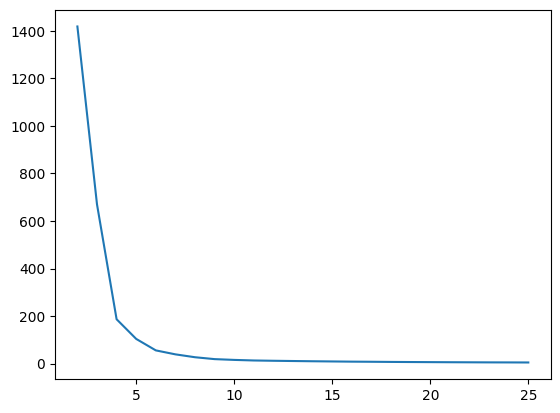

In [17]:
T_sum_squared = []
for i in range(2, 26):
    km = KMeans(n_clusters=i, random_state=0, n_init=10)  # Set n_init explicitly
    km.fit(pca_fit)
    T_sum_squared.append(km.inertia_)
plt.plot(range(2, 26), T_sum_squared, '-')


As we can’t see a clear elbow, we have to use silhouette analysis to find the right k. Silhouette score is a metric for validation of the clustering. We will calculate the silhouette score for each trial of k.

In [19]:
for n in [3, 4, 5, 6, 7, 8]:
    km = KMeans(n_clusters=n, random_state=0, n_init=10)  # Set n_init explicitly
    clusters = km.fit_predict(pca_fit)
    silhouette_avg = silhouette_score(pca_fit, clusters)
    print("For n_clusters =", n, "The average silhouette_score is:", silhouette_avg)
    silhouette_values = silhouette_samples(pca_fit, clusters)

For n_clusters = 3 The average silhouette_score is: 0.996897755465733
For n_clusters = 4 The average silhouette_score is: 0.9962527550301674
For n_clusters = 5 The average silhouette_score is: 0.9588675779453083
For n_clusters = 6 The average silhouette_score is: 0.906992815828906
For n_clusters = 7 The average silhouette_score is: 0.8372575077088922
For n_clusters = 8 The average silhouette_score is: 0.8375180507359612


k=**4**

In [21]:
from matplotlib import cm
Kmeans_final = KMeans(n_clusters=4, random_state=0, n_init=10)  # Set n_init explicitly
Kmeans_final.fit(pca_fit)
data['cluster'] = Kmeans_final.labels_

print(data['cluster'].unique())

[0 2 1 3]


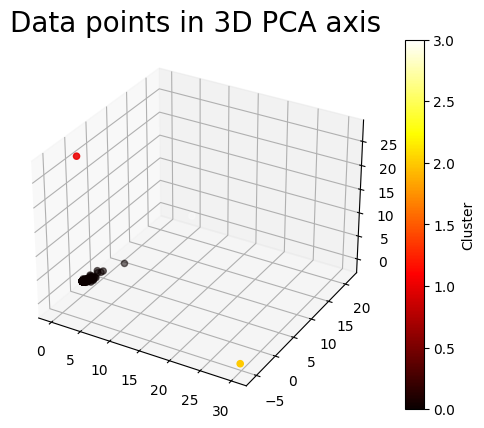

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c=data['cluster'], cmap=cm.hot)
fig.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Data points in 3D PCA axis', fontsize=20)
plt.show()

The user id is given as a input to provide with the recommendations. The books records based on the ISBN is accessed through the user id and the recommendations of the same is produced.

In [23]:
user_id = 276729
user_cluster = data.loc[user_id, 'cluster']
cluster_books = data[data['cluster'] == user_cluster].sum().sort_values(ascending=False)
user_rated_books = user_rating[user_rating['User-ID'] == user_id]['ISBN'].tolist()
recommended_books = cluster_books[~cluster_books.index.isin(user_rated_books)]

In [24]:
# Retrieve book details based on ISBN and display to the user
top_n_recommendations = recommended_books.head(10)
print("Top Recommendations:")
for isbn, count in top_n_recommendations.items(): #can use .iteritems() instead
    book_details = books[books['ISBN'] == isbn]
    print(f"Book: {book_details['Book-Title'].values[0]}, ISBN: {isbn}, Popularity: {count}")

Top Recommendations:
Book: The Lovely Bones: A Novel, ISBN: 316666343, Popularity: 128
Book: The Da Vinci Code, ISBN: 385504209, Popularity: 106
Book: Angels &amp; Demons, ISBN: 671027360, Popularity: 73
Book: Wild Animus, ISBN: 971880107, Popularity: 70
Book: Divine Secrets of the Ya-Ya Sisterhood: A Novel, ISBN: 60928336, Popularity: 65
Book: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), ISBN: 059035342X, Popularity: 64
Book: The Secret Life of Bees, ISBN: 142001740, Popularity: 57
Book: Good in Bed, ISBN: 743418174, Popularity: 57
Book: Where the Heart Is (Oprah's Book Club (Paperback)), ISBN: 446672211, Popularity: 56
Book: The Red Tent (Bestselling Backlist), ISBN: 312195516, Popularity: 55


**Agglomerative**

---You could also use agglomerative methods to depict and analyse the data.



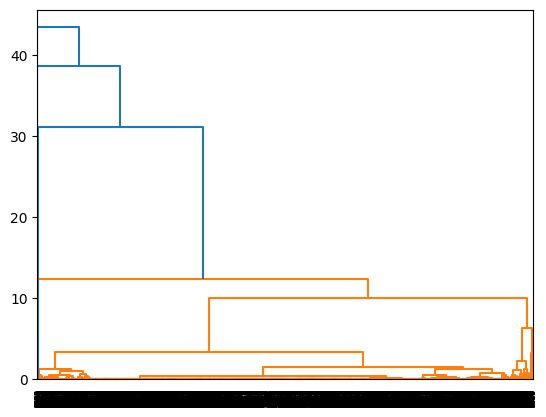

In [25]:
mergings = linkage(pca_fit,method='ward')
dendrogram(mergings)
plt.show()

The dendrogram suggests no. of clusters = 4 will give the best clustering hence we will cut the hierarchy tree where no. of clusters = 4 and check out the silhouette score for clustering.

In [26]:
labels = cut_tree(mergings,n_clusters=4)
d = data.copy()
d['cluster'] = Kmeans_final.labels_
silhouette_avg = silhouette_score(pca_fit, labels)
print("For n_clusters =", 4,
          "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For n_clusters = 4 The average silhouette_score is : 0.9962527550301674


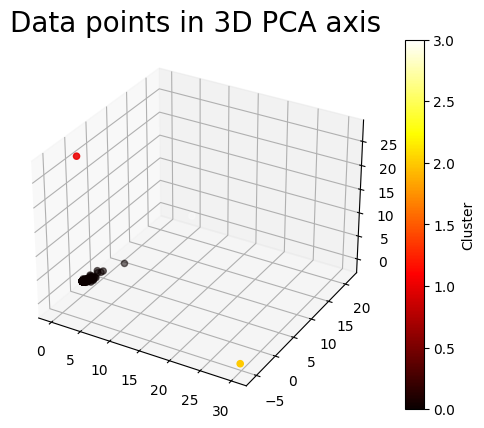

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c=data['cluster'], cmap=cm.hot)
fig.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Data points in 3D PCA axis', fontsize=20)
plt.show()